# Demo: Neural network for classification (PyTorch version)

------------------------------------------------------------------------

*Fraida Fund*

*<small>Attribution: Some parts of this notebook are written by Sundeep Rangan, from his [IntroML GitHub repo](https://github.com/sdrangan/introml/). This notebook was adapted for PyTorch by Rahul Raj at NYU.</small>*

We previously considered a general approach to learning a non-linear function of the input data: we can supply a non-linear data representation, by applying a non-linear transformation to the input data, or specifying a non-linear kernel. Then, the machine learning model learns from the transformed data.

The power of neural networks is their ability to *learn* a “transformation”, rather than having to specify it ourselves! In this demo, we will see how.

## Draw a classification problem

In the following cell, draw on the canvas to fill in the region of the feature space that should be part of the positive class.

In [ ]:
#@title ### Colab drawing magic
# colab drawing magic via
# https://gist.github.com/korakot/8409b3feec20f159d8a50b0a811d3bca
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

canvas_html = """
<canvas width=%d height=%d style='border:1px solid #000000;'></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=256, h=256, line_width=10):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

In [ ]:
draw()

In [1]:
from PIL import Image
import numpy as np
im = Image.open("drawing.png")
np_im = np.array(im)
print(np_im.shape)

(256, 256, 4)


In [2]:
np_im_bw = np_im[:,:,3]

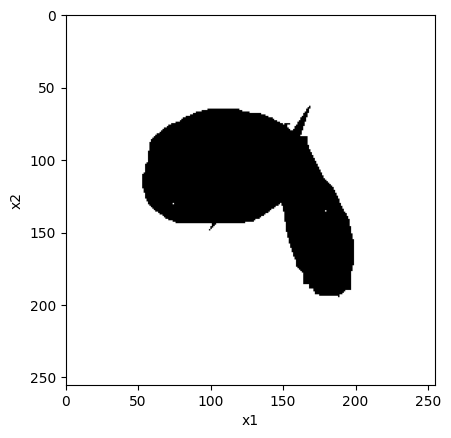

In [3]:
import matplotlib.pyplot as plt

plt.imshow(np_im_bw, cmap='binary');
plt.xlim(0,255);
plt.ylim(255,0);
plt.xlabel('x1');
plt.ylabel('x2');

## Get training, validation, and test data

In [4]:
n_train = 5000
n_val   = 1000
n_test  = 10000

X_train = np.column_stack((np.random.randint(0, np_im_bw.shape[0], size=n_train), np.random.randint(0, np_im_bw.shape[1], size=n_train)))
y_train = np.rot90(np_im_bw, k=3)[X_train[:,0], X_train[:,1]]

X_train = X_train/255.0
y_train = y_train/255.0


X_val = np.column_stack((np.random.randint(0, np_im_bw.shape[0], size=n_val), np.random.randint(0, np_im_bw.shape[1], size=n_val)))
y_val = np.rot90(np_im_bw, k=3)[X_val[:,0], X_val[:,1]]

X_val = X_val/255.0
y_val = y_val/255.0


X_test = np.column_stack((np.random.randint(0, np_im_bw.shape[0], size=n_test), np.random.randint(0, np_im_bw.shape[1], size=n_test)))
y_test = np.rot90(np_im_bw, k=3)[X_test[:,0], X_test[:,1]]

X_test = X_test/255.0
y_test = y_test/255.0

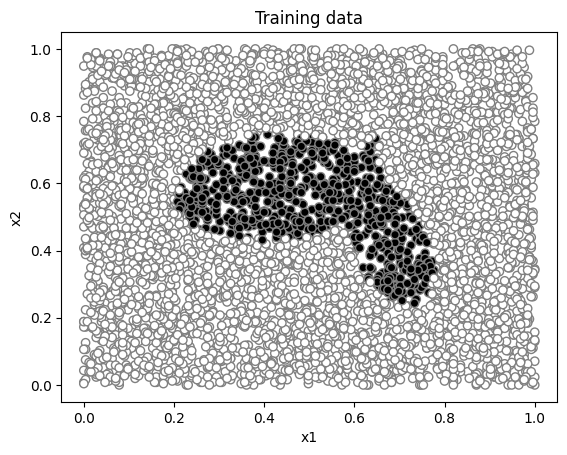

In [5]:
import seaborn as sns

plt.scatter(x=X_train[:,0], y=X_train[:,1], c=y_train, cmap='binary', edgecolors= "gray")
plt.xlabel("x1");
plt.ylabel("x2");
plt.title("Training data");

## Import Pytorch

In this example, we will train a model using Pytorch. You can refer to the [official documentation](https://pytorch.org/) for extra details.

In [9]:
%pip install torch torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\cj\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Using cached torch-2.6.0-cp311-cp311-win_amd64.whl.metadata (28 kB)
  Using cached torchvision-0.21.0-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.6.0-cp311-cp311-win_amd64.whl (204.2 MB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached torchvision-0.21.0-cp311-cp311-win_amd64.whl (1.6 MB)
Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Note: you may need to restart the kernel to use updated packages.


## Create the neural network

We will see if we can build a simple neural network classifier to learn the decision region that we drew above.

First, we create a new class which inherits from a parent class, `nn.Module`: we name this class `SimpleNN`, but we could name it anything we want.

Within this class, we need to define:

-   a `__init__` function that initializes the neural network parameters. We will have two [`nn.Linear` layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) - meaning that the input to the layer is computed as the weighed sum of the outputs of the previous layer.
    -   The first layer is a hidden layer with `nh=4` hidden units,
    -   and there is an output layer with `nout=1` output units corresponding to the estimated class label.
-   a `forward` function. This describes what the network should do in a forward step - in this case, it will apply the sigmoid activation function to its output.

All of the layers are dense or fully connected layers, meaning that each node has a link to every node in the adjacent layers.

In [10]:
nin = 2   # dimension of input data
nh = 10    # number of hidden units
nout = 1  # number of outputs = 1 since this is binary

class SimpleNN(nn.Module):

    def __init__(self, nin, nh, nout):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(nin, nh)
        self.output = nn.Linear(nh, nout)

    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        x = torch.sigmoid(self.output(x))
        return x

In [11]:
model = SimpleNN(nin, nh, nout)
print(model)

SimpleNN(
  (hidden): Linear(in_features=2, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)


In our visualization of the network architechture, we will also add a *bias node* at each layer. This simplifies the computation of weights by adding an extra input whose value is always 1. The bias term then comes from the weight applied to that input.

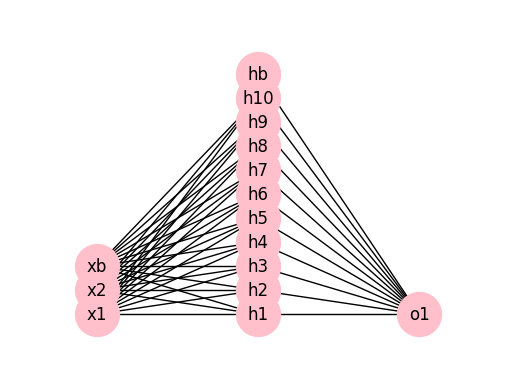

In [12]:
#@title Visualize the network architecture

import networkx as nx

inputLayerSize  = nin
outputLayerSize = nout
hiddenLayerSize = nh


nodePos = {}
G=nx.Graph()
graphHeight = max(inputLayerSize, outputLayerSize, hiddenLayerSize)

# create nodes and note their positions
for n in range(inputLayerSize):
  nodePos['x'+str(n+1)]=(1, n)
  G.add_node('x'+str(n+1))
for n in range(outputLayerSize):
  nodePos['o'+str(n+1)]=(5, n)
  G.add_node('o'+str(n+1))
for n in range(hiddenLayerSize):
  nodePos['h'+str(n+1)]=(3, n)
  G.add_node('h'+str(n+1))

# add edges
for n in range(hiddenLayerSize):
  for m in range(inputLayerSize):
    G.add_edge('x' + str(m+1), 'h' + str(n+1))
  for m in range(outputLayerSize):
    G.add_edge('h' + str(n+1), 'o' + str(m+1))

# add bias nodes

nodePos['xb']=(1, inputLayerSize)
G.add_node('xb')
for n in range(hiddenLayerSize):
  G.add_edge('xb', 'h' + str(n+1))

nodePos['hb']=(3, hiddenLayerSize)
G.add_node('hb')
for n in range(outputLayerSize):
  G.add_edge('hb', 'o' + str(n+1))

nx.draw_networkx(G, pos=nodePos,
              node_size=1000, node_color='pink')
plt.axis('off');
plt.margins(0.2, 0.2);

The neural network needs to learn a weight for each link in the image above (including the weights for the bias nodes).

## Train the neural network

To train the network, we have to select an optimizer and a loss function.

Since this is a binary classification problem, we select the [binary cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html).

We will also choose an [optimizer (Adam)](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) and a learning rate of learning_rate=0.01.

<small>Reference: [pytorch loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions), [optimizers](https://pytorch.org/docs/stable/optim.html)</small>

In [13]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

To pass data to our model, we will prepare a [`DataLoader`](https://pytorch.org/docs/stable/data.html) - this will iterate over the data and “batch” it for us according to the batch size we specify.

In [14]:
# Create data loaders for our datasets; shuffle for training, not for validation
batch_size = 1
train_loader = DataLoader(
    TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)),
    batch_size = batch_size, shuffle=True)
val_loader = DataLoader(
    TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val)),
    batch_size = batch_size, shuffle=False)
test_loader = DataLoader(
    TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)),
    batch_size = batch_size, shuffle=False)

Now we are ready to define our training function! On each iteration of the loop, we:

-   Get a batch of training data from the `train_loader`.
-   Zero the gradients of the `optimizer`. (This is necessary because by default, they accumulate.)
-   Do a forward pass on the batch of training data.
-   Use the predictions from this forward pass to compute the loss.
-   Then, do a backwards pass where we compute the gradients.
-   Update the weights of the optimizer using these gradients.

In [15]:
def train_one_epoch(data_loader):

    # Put model in training mode
    model.train(True)

    running_loss    = 0
    running_correct = 0
    running_samples = 0

    for i, data in enumerate(data_loader):
        # Every data instance is an X, y pair
        X, y = data
        y = y.unsqueeze(1) # make it the same shape as predictions

        # Zero gradients for every batch!
        optimizer.zero_grad()

        # Forward pass makes predictions for this batch
        y_pred = model(X)

        # Compute the loss and its gradients
        loss = loss_fn(y_pred, y)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Update running loss, accuracy, and number of samples
        running_correct += ( (y_pred >= 0.5) == y).sum().item()
        running_samples += y.size(0)
        running_loss    += loss*y.size(0)

    # return average loss, average accuracy
    return float(running_loss/running_samples), float(running_correct/running_samples)

We will also define a function for evaluating the model without training:

In [16]:
def eval_model(data_loader):

    running_loss    = 0
    running_correct = 0
    running_samples = 0

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation for faster computation/reduced memory
    with torch.no_grad():

      for i, data in enumerate(data_loader):
          # Every data instance is an X, y pair
          X, y = data
          y = y.unsqueeze(1) # make it the same shape as predictions

          # Forward pass makes predictions for this batch
          y_pred = model(X)

          # Compute the loss
          loss = loss_fn(y_pred, y)

          # Update running loss, accuracy, and number of samples
          running_correct += ( (y_pred.data >= 0.5) == y).sum().item()
          running_samples += y.size(0)
          running_loss    += loss*y.size(0)

    # return average loss, average accuracy
    return float(running_loss/running_samples), float(running_correct/running_samples)

Now, we will loop over epochs, train the model for one epoch, and then evaluate its performance on the validation data at the end of each epoch.

In [17]:
n_epochs = 100
metrics = {'train_losses': [], 'train_accuracies': [], 'val_losses': [], 'val_accuracies': []}

for epoch in range(n_epochs):

    # Train on training data
    train_loss, train_accuracy = train_one_epoch(train_loader)
    metrics['train_losses'].append(train_loss)
    metrics['train_accuracies'].append(train_accuracy)

    # Evaluate on validation data
    val_loss, val_accuracy = eval_model(val_loader)
    metrics['val_losses'].append(val_loss)
    metrics['val_accuracies'].append(val_accuracy)

    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {train_loss:.4f} - Accuracy: {train_accuracy:.4f} - Val_Loss: {val_loss:.4f} - Val_Accuracy: {val_accuracy:.4f}')


Epoch 1/100 - Loss: 0.4204 - Accuracy: 0.8506 - Val_Loss: 0.4404 - Val_Accuracy: 0.8280
Epoch 2/100 - Loss: 0.3807 - Accuracy: 0.8522 - Val_Loss: 0.4098 - Val_Accuracy: 0.8280
Epoch 3/100 - Loss: 0.2997 - Accuracy: 0.8570 - Val_Loss: 0.2533 - Val_Accuracy: 0.8720
Epoch 4/100 - Loss: 0.2138 - Accuracy: 0.9000 - Val_Loss: 0.1892 - Val_Accuracy: 0.9180
Epoch 5/100 - Loss: 0.1784 - Accuracy: 0.9244 - Val_Loss: 0.1630 - Val_Accuracy: 0.9420
Epoch 6/100 - Loss: 0.1619 - Accuracy: 0.9296 - Val_Loss: 0.1696 - Val_Accuracy: 0.9260
Epoch 7/100 - Loss: 0.1522 - Accuracy: 0.9350 - Val_Loss: 0.1597 - Val_Accuracy: 0.9200
Epoch 8/100 - Loss: 0.1487 - Accuracy: 0.9326 - Val_Loss: 0.1541 - Val_Accuracy: 0.9450
Epoch 9/100 - Loss: 0.1408 - Accuracy: 0.9372 - Val_Loss: 0.1210 - Val_Accuracy: 0.9580
Epoch 10/100 - Loss: 0.1346 - Accuracy: 0.9414 - Val_Loss: 0.1223 - Val_Accuracy: 0.9560
Epoch 11/100 - Loss: 0.1304 - Accuracy: 0.9422 - Val_Loss: 0.1377 - Val_Accuracy: 0.9370
Epoch 12/100 - Loss: 0.1260 - 

## Visualize output of network

To see the classification rule our neural network learned, we can plot the predicted class probability over the input space.

We can also plot the response in the each of the hidden units.

Each of the hidden units produces one linear decision region. The final nonlinear region is then formed by taking a weighted combination of these regions.

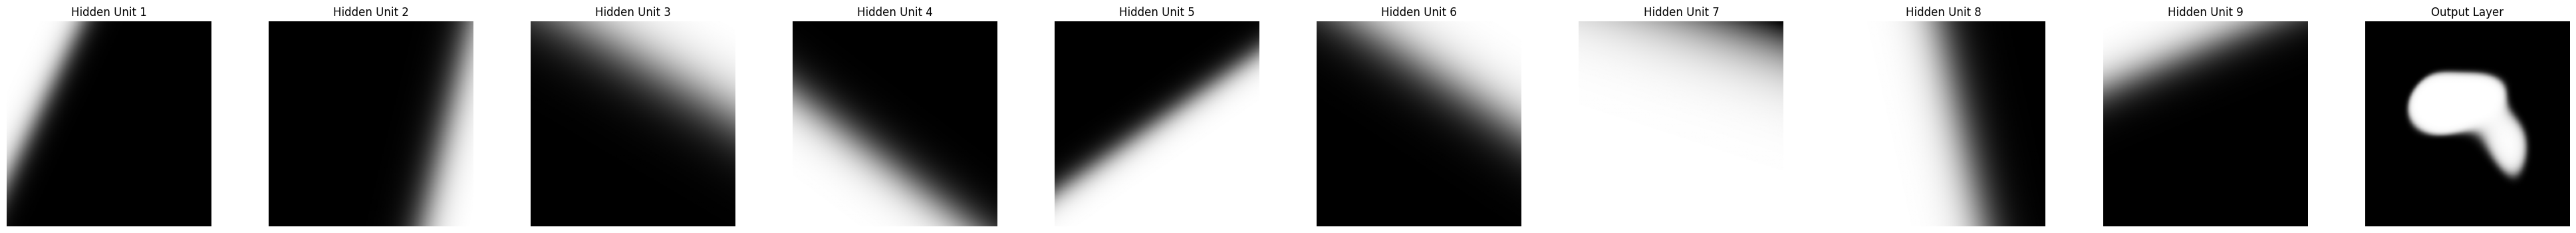

In [18]:
#@title Visualize output of each unit

model.eval()

# Generate a grid of points
n_plot = 256
xx1, xx2 = np.meshgrid(np.linspace(0, 1, n_plot), np.linspace(0, 1, n_plot))
X_grid = np.hstack((xx1.reshape(n_plot**2, 1), xx2.reshape(n_plot**2, 1)))
X_grid_tensor = torch.tensor(X_grid, dtype=torch.float32)

# Function to capture outputs of the desired layer
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

# Register hook for hidden layer
hook_handle = model.hidden.register_forward_hook(get_activation)

# Pass the grid through the model
with torch.no_grad():
    output = model(X_grid_tensor)

# Remove the hook
hook_handle.remove()

# Reshape the activations and output to plot them
activation = activation.numpy().reshape((n_plot, n_plot, -1))
output = output.numpy().reshape((n_plot, n_plot))

# Visualization
fig, axes = plt.subplots(1, nh, figsize=(nh*5, 4))

# Plot for each hidden unit with grayscale colormap
for i in range(activation.shape[2]):
    axes[i].imshow(activation[:, :, i], cmap='gray', origin='lower', extent=[0,1,0,1])
    axes[i].set_title(f'Hidden Unit {i+1}')
    axes[i].axis('off')

# Plot for output layer with grayscale colormap
axes[-1].imshow(output, cmap='gray', origin='lower', extent=[0,1,0,1])
axes[-1].set_title('Output Layer')
axes[-1].axis('off')

plt.show()

We can also check all of the parameters learned by the network:

In [19]:
# Accessing weights and biases of the hidden layer
hidden_layer = model.hidden
Wh = hidden_layer.weight.data.numpy()
bh = hidden_layer.bias.data.numpy()

print('Hidden Layer Weights (Wh)=\n', Wh)
print('Hidden Layer Biases (bh)=\n', bh)

# Accessing weights and biases of the output layer
output_layer = model.output
Wo = output_layer.weight.data.numpy()
bo = output_layer.bias.data.numpy()

print('Output Layer Weights (Wo)=\n', Wo)
print('Output Layer Biases (bo)=\n', bo)

Hidden Layer Weights (Wh)=
 [[-27.22357    12.868453 ]
 [ 19.962448   -4.8022537]
 [  6.0286     10.323913 ]
 [-10.278649  -13.682781 ]
 [ 16.306814  -23.694645 ]
 [  7.4717464  11.429228 ]
 [ -2.8409843  -8.67168  ]
 [-15.866754   -3.4843142]
 [ -6.9868364  16.521574 ]
 [  7.1057997  10.798069 ]]
Hidden Layer Biases (bh)=
 [ -2.8575828 -14.968718  -11.489402    8.951308    3.9001997 -12.780875
  11.342216   11.085675  -11.057283  -12.245243 ]
Output Layer Weights (Wo)=
 [[-20.912405 -28.467669  -8.269671 -27.050781 -16.877348 -20.870247
   16.1583   -14.639372 -22.481451 -14.510521]]
Output Layer Biases (bo)=
 [12.030372]


And, we can visualize the training progress vs. epoch:

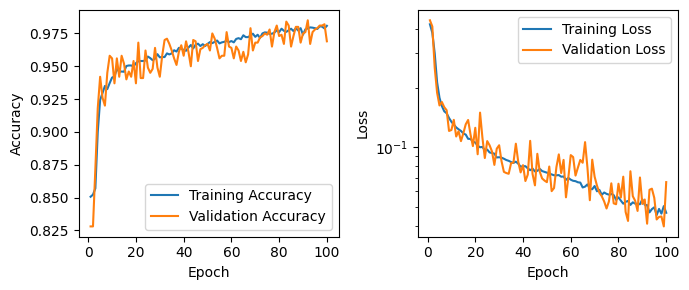

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 3))

plt.subplot(1,2,1)
nepochs = len(metrics['train_accuracies'])
sns.lineplot(x=np.arange(1, nepochs+1), y=metrics['train_accuracies'], label='Training Accuracy')
sns.lineplot(x=np.arange(1, nepochs+1), y=metrics['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
sns.lineplot(x=np.arange(1, nepochs+1), y=metrics['train_losses'], label='Training Loss')
sns.lineplot(x=np.arange(1, nepochs+1), y=metrics['val_losses'], label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()


## Measure performance on test set

In [21]:
test_loss, test_accuracy = eval_model(test_loader)
print(f'Accuracy on the test set: {test_accuracy:.4f}')

Accuracy on the test set: 0.9738


In [22]:
y_pred_all = []
y_all      = []
with torch.no_grad():
    for X, y in test_loader:
        y_pred = model(X)
        y_pred_label = (y_pred.data > 0.5).float()
        y_pred_all.extend(y_pred_label.numpy())
        y_all.extend(y.numpy())

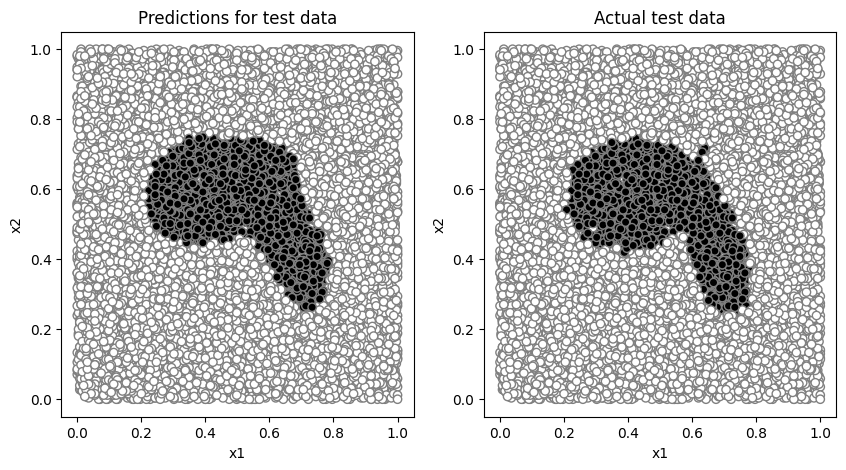

In [23]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=np.array(y_pred_all).flatten(), cmap='binary', edgecolors="gray")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Predictions for test data")

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=np.array(y_all).flatten(), cmap='binary', edgecolors="gray")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Actual test data")

plt.show()


## Things to try

-   What happens if we use linear activations, instead of sigmoid?
-   When do we need to use a large number of hidden units?
-   Try to adjust the learning rate and batch size. What is the effect?
-   What should you do if you want to train the model for a few more epochs? What should you do if you want to train the model from scratch?